In [1]:
import numpy as np 
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklift.metrics import (uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift)
from sklearn.model_selection import KFold

In [2]:
df_x5 = pd.read_csv('retail_hero_final_model_train_data.csv', index_col='client_id')

In [3]:
df_x5 = pd.read_csv('retail_hero_final_model_train_data.csv', index_col='client_id')
df_features, w, y = df_x5[['first_redeem_date', 'express_spent_mean',
       'express_points_spent_sum', 'regular_points_received_sum_last_m',
       'avg_spent_perday', 'after_redeem_sum_perday']], df_x5['treatment_flg'], df_x5['target']

def x5_coding(x):
    return int(str(int(x['treatment_flg']))+str(int(x['target'])), 2)

df_x5['coding'] = df_x5.apply(x5_coding, axis=1)
c = df_x5['coding']

from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(df_x5.index, test_size=0.3,random_state=0)
X_train, w_train, y_train, c_train = df_features.loc[indices_learn].fillna(0), w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = df_features.loc[indices_valid].fillna(0), w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

In [4]:
def grid_search_tree(model, params, X_train, y_train, w_train):
    
    best_qini_score = 0
    best_model_qini = 0
    kf = KFold(n_splits=5,random_state=1,shuffle=True)
        
    for i in ParameterGrid(params):
        tr = model(**i)
        qini_auc=[]

        for train_index, test_index in kf.split(X_train):
            X_train_split, X_test_split = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[test_index]]
            y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
            w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]]

            tr.fit(X=X_train_split.values, w=w_train_split.values, y=y_train_split.values)
            predict_lrn, prob = tr.predict(X_test_split.values)
            qini_auc.append(qini_auc_score(y_true= y_test_split, uplift=np.array(predict_lrn).astype(int), treatment=np.array(w_test_split).astype(int)))
#             print( np.unique(predict_lrn, return_counts=True), qini_auc[-1], i)
#         print(np.mean(qini_auc), i, qini_auc)
        if np.mean(qini_auc) > np.mean(best_qini_score):
            best_qini_score = np.mean(qini_auc)
            best_model_qini = i
                
            
    return best_model_qini, best_qini_score

In [5]:
from tree_uplift import UpliftTree, RandomForestUplift

In [6]:
models = [UpliftTree, RandomForestUplift]
utc_params = {'max_depth':[6, 8, 10, 12], 'scoring':['KL', 'ED', 'Chi'], 'norm':[False, True], 'random_state':[0], 'n_rand_features':[5]}
rfu_params = {'n_estimators':[10, 30, 50], 'max_depth':[6, 8, 10], 'scoring':['KL', 'ED', 'Chi'], 'norm':[True, False], 'random_state':[0], 'n_rand_features':[5]}

In [8]:
qini = []
params = []
for model, param in zip(models, [utc_params, rfu_params]):
    p, q = grid_search_tree(model, param, X_train.fillna(0), y_train, w_train)
    print(p, q)
    params.append(p)
    qini.append(q)

{'max_depth': 8, 'scoring': 'Chi', 'norm': False, 'random_state': 0, 'n_rand_features': 5} 0.0009928032900178194
{'n_estimators': 30, 'max_depth': 8, 'scoring': 'Chi', 'norm': False, 'random_state': 0, 'n_rand_features': 5} 0.0028089234076546168


In [39]:
from copy import deepcopy

In [40]:
kf = KFold(n_splits=5,random_state=2,shuffle=True)
names = ['Uplift Tree', 'Uplift Random Forest']
print('Scores on train:')
for model, param, name in zip(models, params, names):
    models_ = []
    scores = []
    tr = model(**param)
    for train_index, test_index in kf.split(X_train):
            X_train_split, X_test_split = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[test_index]]
            y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
            w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]]

            tr.fit(X_train_split, y_train_split, w_train_split)
            models_.append(deepcopy(tr))
            predict_lrn, _ = tr.predict(X_test_split)
            scores.append(uplift_at_k(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split, strategy='overall', k=0.3))
    print(name + f': mean uplift_at_k {np.mean(scores)}, variance {np.var(scores)}')
    uplift = []
    print('Scores on test:')
    for model in models_:
        predict_lrn, _ = model.predict(X_valid)
        uplift.append(uplift_at_k(y_true= y_valid, uplift=predict_lrn, treatment=w_valid, strategy='overall', k=0.3))
    print(name + f': mean uplift_at_k {np.mean(uplift)}, variance {np.var(uplift)}')


Scores on train:
Uplift Tree: mean uplift_at_k 0.033032860325884775, variance 4.181850736570572e-05
Scores on test:
Uplift Tree: mean uplift_at_k 0.0421933648454391, variance 5.1760334871480527e-05
Uplift Random Forest: mean uplift_at_k 0.03831530463888248, variance 9.50101182080146e-05
Scores on test:
Uplift Random Forest: mean uplift_at_k 0.03861185301719603, variance 4.4180667148389934e-07


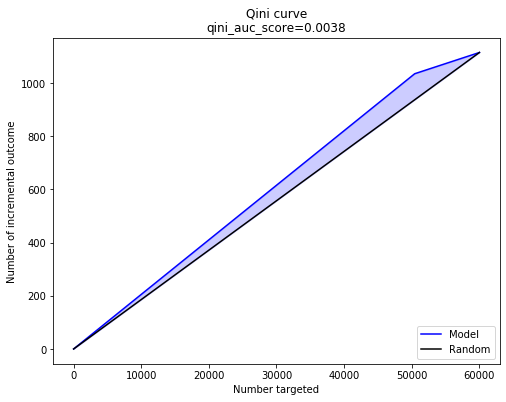

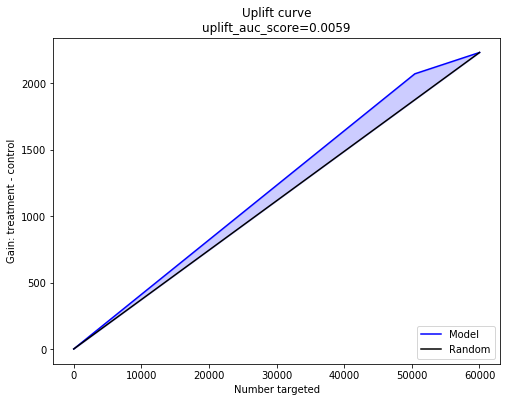

In [43]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
%matplotlib inline
plot_qini_curve(y_true=y_valid, uplift=predict_lrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_lrn, treatment=w_valid, perfect=False)

In [48]:
from sklearn.preprocessing import OneHotEncoder

def kuusisto_coding(x):
    return int(str(x['w'])+str(x['target']), 2)

def kuusisto_preprocessing(df):
    
    df = df.drop(['customer_type'],axis=1)
    df['target'] = df['outcome'].apply(lambda x: 1 if x=='positive' else 0)
    df['w'] = df['target_control'].apply(lambda x: 1 if x=='target' else 0) 
    df['coding'] = df.apply(kuusisto_coding, axis=1)  
    df = df.drop(['outcome','target_control'],axis=1)
    
    ohe = OneHotEncoder(sparse=False)
    encoded_features = pd.DataFrame(ohe.fit_transform(df[['Node1','Node2','Node3','Node4',
                                                          'Node5','Node6','Node7','Node8',
                                                          'Node9','Node10','Node11','Node12',
                                                          'Node13','Node14','Node15','Node17',
                                                          'Node18','Node19','Node20']]))
    
    df = df.drop(['Node1','Node2','Node3','Node4','Node5','Node6','Node7',
                  'Node8','Node9','Node10','Node11','Node12','Node13','Node14',
                  'Node15','Node17','Node18','Node19','Node20'],axis=1)
    
    df = pd.concat([df,encoded_features],axis=1)
    df = df.dropna()
    c = df['coding']
    y = df['target']
    w = df['w']
    X = df.drop(['target','w','coding'],axis=1)
        
    return X,y,w,c

In [64]:
df = pd.read_csv('stereotypical_customer_simulation.csv',index_col='customer_id')
X, y, w, c  = kuusisto_preprocessing(df)
from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(X.index, test_size=0.3,random_state=0)
X_train, w_train, y_train, c_train = X.loc[indices_learn], w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = X.loc[indices_valid], w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

In [72]:
qini_k = []
params_k = []
for model, param in zip(models, [utc_params, rfu_params]):
    p, q = grid_search_tree(model, param, X_train.astype(str), y_train,w_train)
    params_k.append(p)
    qini_k.append(q)

[0. 0. 0. ... 0. 0. 0.] 0.011479958307325224 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'KL'}
[1. 1. 0. ... 1. 1. 0.] -0.007703603050669688 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'KL'}
[1. 1. 1. ... 1. 0. 1.] -0.0014875967597164134 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'KL'}
[0. 0. 0. ... 0. 0. 0.] 0.011479958307325224 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'ED'}
[1. 1. 0. ... 1. 1. 0.] -0.02245322140867527 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'ED'}
[1. 1. 1. ... 1. 0. 1.] -0.008367375446049504 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'ED'}
[0. 0. 0. ... 0. 0. 0.] 0.007955531829844636 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}
[1. 1. 0. ... 1. 1. 0.] -0.021744161239515225 {'max_depth': 6, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}
[1. 1. 1. ... 1. 0. 1.] -0.0014875967597164134 {'max_depth': 6, 'norm': True, 'random_sta

[0 1 0 ... 0 0 0] 0.006164981239240798 {'max_depth': 6, 'n_estimators': 10, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}
[1 0 0 ... 1 1 1] -0.00316416136030283 {'max_depth': 6, 'n_estimators': 10, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}
[0 0 1 ... 1 0 0] 0.008317978955883971 {'max_depth': 6, 'n_estimators': 10, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}
[1 1 0 ... 1 0 0] -0.01135278488808184 {'max_depth': 6, 'n_estimators': 10, 'norm': False, 'random_state': 42, 'scoring': 'Chi'}
[0 1 0 ... 1 1 1] -0.029965623572584206 {'max_depth': 6, 'n_estimators': 10, 'norm': False, 'random_state': 42, 'scoring': 'Chi'}
[1 1 1 ... 1 1 1] -0.001605873862290294 {'max_depth': 6, 'n_estimators': 10, 'norm': False, 'random_state': 42, 'scoring': 'Chi'}
[0 1 1 ... 1 0 0] -0.008335063529150533 {'max_depth': 6, 'n_estimators': 30, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}
[1 0 1 ... 1 1 1] 0.009680856432499545 {'max_depth': 6, 'n_estimators': 30, 'norm': True, 'random_

In [73]:
print(params_k, qini_k)

[{'max_depth': 10, 'norm': False, 'random_state': 42, 'scoring': 'ED'}, {'max_depth': 10, 'n_estimators': 50, 'norm': False, 'random_state': 42, 'scoring': 'Chi'}] [[0.008941815765190408, 0.0066066182419982885, 0.004450506288587821], [0.010935164780782047, 0.007105979710618592, 0.0028429895685940015]]


In [77]:
X_train_new = X_train.astype(str).copy()
kf = KFold(n_splits=5,random_state=2,shuffle=True)
names = ['Uplift Tree', 'Uplift Random Forest']
for model, param, name in zip(models, params_k, names):
    models_ = []
    scores = []
    tr = model(**param)
    print('Scores on train:')
    for train_index, test_index in kf.split(X_train_new):
            X_train_split, X_test_split = X_train_new.loc[X_train.index[train_index]], X_train_new.loc[X_train.index[test_index]]
            y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
            w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]]

            tr.fit(X_train_split, y_train_split, w_train_split)
            models_.append(deepcopy(tr))
            predict_lrn, _ = tr.predict(X_test_split)
            scores.append(uplift_at_k(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split, strategy='overall', k=0.3))
    print(name + f': mean uplift_at_k {np.mean(scores)}, variance {np.var(scores)}')
    uplift = []
    print('Scores on test:')
    for model in models_:
        predict_lrn, _ = model.predict(X_valid)
        uplift.append(uplift_at_k(y_true= y_valid, uplift=predict_lrn, treatment=w_valid, strategy='overall', k=0.3))
    print(name + f': mean uplift_at_k {np.mean(uplift)}, variance {np.var(uplift)}')


Scores on train:
Uplift Tree: mean uplift_at_k 0.008834230923778497, variance 0.0028702567655571895
Scores on test:
Uplift Tree: mean uplift_at_k 0.012093726379440728, variance 0.0
Scores on train:
Uplift Random Forest: mean uplift_at_k 0.01805825516581209, variance 0.0014856976607521759
Scores on test:
Uplift Random Forest: mean uplift_at_k 0.012093726379440728, variance 0.0


In [121]:
from sklift.datasets import fetch_hillstrom
from sklearn.preprocessing import OneHotEncoder
def mine_coding(dataset):
    return int(str(int(dataset['segment']))+str(int(dataset['visit'])), 2)

def mine_preproccessing():  
    bunch = fetch_hillstrom(target_col='visit')

    dataset, target, treatment = bunch['data'], bunch['target'], bunch['treatment']

    # Selecting two segments
    dataset = dataset[treatment!='Mens E-Mail']
    target = target[treatment!='Mens E-Mail']
    treatment = treatment[treatment!='Mens E-Mail'].map({
        'Womens E-Mail': 1,
        'No E-Mail': 0
    })
    dataset = dataset.dropna()
    cat_cols = dataset.select_dtypes(include='object').columns.tolist()
    ohe = OneHotEncoder(sparse=False)
    encoded_features = pd.DataFrame(ohe.fit_transform(dataset[cat_cols]))

    dataset = pd.concat([dataset,target,treatment],axis=1)
    dataset = dataset.drop(cat_cols,axis=1)
    dataset = pd.concat([dataset,encoded_features],axis=1)
    dataset = dataset.dropna()

    dataset['coding'] = dataset.apply(mine_coding, axis=1) 

    c = dataset['coding']
    y = dataset['visit'].astype(int)
    w = dataset['segment'].astype(int)
    X = dataset.drop(['visit','segment','coding'],axis=1)

    return X,y,w,c

In [139]:
X_mine,y_mine,w_mine,c_mine = mine_preproccessing()

In [147]:
X_mine[['mens',  'womens',  'newbie',         0,
               1,         2,         3,         4,         5,         6,
               7,         8,         9,        10,        11,        12]] = X_mine[['mens',  'womens',  'newbie',         0,
               1,         2,         3,         4,         5,         6,
               7,         8,         9,        10,        11,        12]].astype(str)

In [148]:
indices_learn, indices_valid = train_test_split(X_mine.index, test_size=0.3)
X_train, w_train, y_train, c_train = X_mine.loc[indices_learn], w_mine.loc[indices_learn], y_mine.loc[indices_learn], c_mine.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = X_mine.loc[indices_valid], w_mine.loc[indices_valid], y_mine.loc[indices_valid], c_mine.loc[indices_valid]

In [96]:
qini_m = []
params_m = []
for model, param in zip(models, [utc_params, rfu_params]):
    p, q = grid_search_tree(model, param, X_train, y_train,w_train)
    params_m.append(p)
    qini_m.append(q)

In [97]:
print(params_m, qini_m)

[{'max_depth': 6, 'norm': False, 'random_state': 42, 'scoring': 'ED'}, {'max_depth': 8, 'n_estimators': 30, 'norm': True, 'random_state': 42, 'scoring': 'Chi'}] [[0.016392726102191363, 0.05302375587185775, 0.033643685488507324], [0.017680479312504972, 0.011634268120174708, 0.027195780804460327]]


In [150]:
kf = KFold(n_splits=5,random_state=2,shuffle=True)
names = ['Uplift Tree', 'Uplift Random Forest']
for model, param, name in zip(models, params_m, names):
    models_ = []
    scores = []
    tr = model(**param)
    print('Scores on train:')
    for train_index, test_index in kf.split(X_train):
            X_train_split, X_test_split = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[test_index]]
            y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
            w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]]

            tr.fit(X_train_split, y_train_split, w_train_split)
            models_.append(deepcopy(tr))
            predict_lrn, _ = tr.predict(X_test_split)
            scores.append(uplift_at_k(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split, strategy='overall', k=0.3))
    print(name + f': mean uplift_at_k {np.mean(scores)}, variance {np.var(scores)}')
    uplift = []
    print('Scores on test:')
    for model in models_:
        predict_lrn, _ = model.predict(X_valid)
        uplift.append(uplift_at_k(y_true= y_valid, uplift=predict_lrn, treatment=w_valid, strategy='overall', k=0.3))
    print(name + f': mean uplift_at_k {np.mean(uplift)}, variance {np.var(uplift)}')

Scores on train:
Uplift Tree: mean uplift_at_k 0.05088957690695093, variance 0.0002881523621408037
Scores on test:
Uplift Tree: mean uplift_at_k 0.051436840583622204, variance 0.00014208081600303442
Scores on train:
Uplift Random Forest: mean uplift_at_k 0.04486540839866745, variance 0.0002783526983676229
Scores on test:
Uplift Random Forest: mean uplift_at_k 0.04339136486350666, variance 3.485295012995379e-05


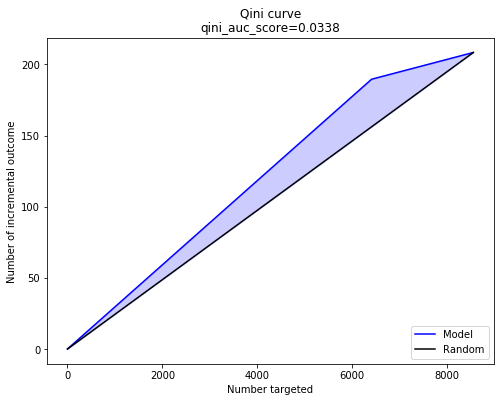

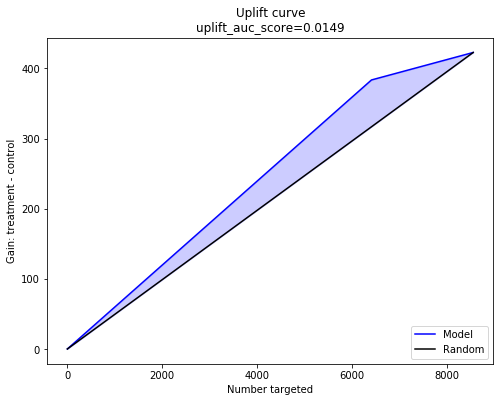

In [151]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
%matplotlib inline
plot_qini_curve(y_true=y_valid, uplift=predict_lrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_lrn, treatment=w_valid, perfect=False)

In [154]:
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier

In [160]:
urf = UpliftTreeClassifier(max_depth=6, evaluationFunction='ED', normalization=False, control_name='0')
urf.fit(X_train.values, w_train.astype(str).values, y_train.values,)
predict_lrn, _ = urf.predict(X_valid.values)

In [164]:
# Uplift at k best
uplift_k = uplift_at_k(y_true=y_valid, uplift=np.array(predict_lrn).astype(int), treatment=w_valid, strategy='overall', k=0.3)
# Area Under Qini Curve
tm_qini_auc = qini_auc_score(y_true=y_valid, uplift=np.array(predict_lrn).astype(int), treatment=w_valid)

# Area Under Uplift Curve
tm_uplift_auc = uplift_auc_score(y_true=y_valid, uplift=np.array(predict_lrn).astype(int), treatment=w_valid)

# Weighted average uplift
tm_wau = weighted_average_uplift(y_true=y_valid, uplift=np.array(predict_lrn).astype(int),  treatment=w_valid)

print("Tree: ", tm_qini_auc, tm_uplift_auc, tm_wau, uplift_k)

Tree:  0.017028946176102285 0.00740588721969744 0.04940117696355619 0.04378093006523873


In [153]:
params_m

[{'max_depth': 6, 'norm': False, 'random_state': 42, 'scoring': 'ED'},
 {'max_depth': 8,
  'n_estimators': 30,
  'norm': True,
  'random_state': 42,
  'scoring': 'Chi'}]